In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import pickle
import os.path as osp
import os
import logging
import random
import seaborn as sns
import warnings
import xgboost as xgb
import zipfile

from glob import glob
from pandas import Timestamp
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from tqdm.notebook import tqdm
from urllib.request import urlopen 

logging.getLogger().setLevel('INFO')
warnings.simplefilter(action='ignore', category=FutureWarning)
tqdm.pandas()

## Helpers

In [2]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Download the dataset

In [3]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)
   
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

# Issue when loading '.xlsx' file, must use 'openpyxl' in this case
df_atp = pd.concat([pd.read_excel(f) if f[-1]=='s' else pd.read_excel(f, engine='openpyxl') for f in ATP_FILES], ignore_index=True)
df_wta = pd.concat([pd.read_excel(f) if f[-1]=='s' else pd.read_excel(f, engine='openpyxl') for f in WTA_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

INFO:root:downloading & extracting file http://tennis-data.co.uk/2000/2000.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2001/2001.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2002/2002.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2003/2003.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2004/2004.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2005/2005.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2006/2006.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2007/2007.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2008/2008.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2009/2009.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2010/2010.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2011/2011.zip
INFO:root:downloading & extracting file http://tenni

## Your work

### Questions

#### Question 1: Who are the three ATP players with the most wins ?

In [4]:
df_atp.groupby('Winner')['Winner'].count().sort_values(ascending=False)[0:3]

Winner
Federer R.     1121
Nadal R.        891
Djokovic N.     802
Name: Winner, dtype: int64

The top 3 winners of the ATP between 2000-2018 are:
- Federer R. with 1121 wins
- Nadal R. with 891 wins
- Djokovic N. with 802 wins

#### Question 2: How many sets did the player “ Federer R.” win in total ?

In [5]:
sets_won_as_winner = pd.to_numeric(df_atp.loc[df_atp['Winner'] == 'Federer R.']['Wsets'], errors='coerce').sum() 
sets_won_as_loser = pd.to_numeric(df_atp.loc[df_atp['Loser'] == 'Federer R.']['Lsets'], errors='coerce').sum() 

total_sets_won = sets_won_as_winner + sets_won_as_loser
total_sets_won

2695.0

Federer R. won **2695 sets** between 2000-2018.

#### Question 3: How many sets did the player “ Federer R.” win during the years 2016 and 2017 ?

In [6]:
sets_won_as_winner_2016_2017 = pd.to_numeric(df_atp.loc[(df_atp['Winner'] == 'Federer R.') & 
                                                        (df_atp['Date'] >= Timestamp('2016-01-01 00:00:00')) &
                                                        (df_atp['Date'] < Timestamp('2018-01-01 00:00:00'))]['Wsets'], errors='coerce').sum()

sets_won_as_loser_2016_2017 = pd.to_numeric(df_atp.loc[(df_atp['Loser'] == 'Federer R.') & 
                                                       (df_atp['Date'] >= Timestamp('2016-01-01 00:00:00')) &
                                                       (df_atp['Date'] < Timestamp('2018-01-01 00:00:00'))]['Lsets'], errors='coerce').sum()

total_sets_won_2016_2017 = sets_won_as_winner_2016_2017 + sets_won_as_loser_2016_2017
total_sets_won_2016_2017

182.0

Federer R. won **182 sets** between in 2016 and 2017.

#### Question 4: For each match, what is the percentage of victories of the winner in the past ?

In [7]:
def compute_winner_past_win_ratio(df_atp):
    """
    Compute the Winner past win ratio at the beginning of a each match. We use a DATA_CACHE in order to more 
    efficiently
    
    Inputs 
    --------
    df_atp : DataFrame : original tennis match's dataframe
    
    Returns 
    --------
    df_atp : DataFrame : dataframe with the computed 'Winner win ratio' column
    """
    df_atp["Winner win ratio"] = np.nan
    
    all_player_names = set(list(df_atp['Winner'].unique()) + list(df_atp['Loser'].unique()))
    DATA_CACHE = {player_name: [0, 0] for player_name in all_player_names} # set all players to 0 match won, 0 match played

    for index, row in tqdm(df_atp.iterrows(), total=df_atp.shape[0]):
        # Winner has already played at least one match
        if DATA_CACHE[row['Winner']][1] > 0:
            win_ratio = round(DATA_CACHE[row['Winner']][0] / DATA_CACHE[row['Winner']][1], 4)
            df_atp.loc[index, "Winner win ratio"] = win_ratio
        
        # One more match added to Winner won match and total number of match 
        DATA_CACHE[row['Winner']][0] += 1 
        DATA_CACHE[row['Winner']][1] += 1
        
        # One more match added to Loser total number of match 
        DATA_CACHE[row['Loser']][1] += 1
        
    return df_atp

In [8]:
df_atp = compute_winner_past_win_ratio(df_atp)

  0%|          | 0/52298 [00:00<?, ?it/s]

In [9]:
df_atp[['Tournament', 'Winner', 'Loser', 'Winner win ratio']].tail(10)

,Tournament,Winner,Loser,Winner win ratio
52288,Masters Cup,Federer R.,Thiem D.,0.8289
52289,Masters Cup,Djokovic N.,Zverev A.,0.8297
52290,Masters Cup,Cilic M.,Isner J.,0.6515
52291,Masters Cup,Thiem D.,Nishikori K.,0.6301
52292,Masters Cup,Federer R.,Anderson K.,0.8290
52293,Masters Cup,Zverev A.,Isner J.,0.6640
52294,Masters Cup,Djokovic N.,Cilic M.,0.8299
52295,Masters Cup,Zverev A.,Federer R.,0.6654
52296,Masters Cup,Djokovic N.,Anderson K.,0.8301
52297,Masters Cup,Zverev A.,Djokovic N.,0.6667


### Tennis Match Prediction

In this notebook, we predict the outcome (who is the winner) for each ATP tennis game during the year **2017**. 

During the model's training, we remained very careful about not corrupting our learnings with data from year 2017. To do so, year 2017 data remained untouched during our training/validation/analysis procedure. We simulate betting with 2 simple strategies on 2017 Tennis' matchs and show their potential gain. 

Table of contents of our approach:

- **Data Preparation Process**:
        - Data Checking & Cleaning 
        - Randomization of dataset
        - Categorical Encoding & Features Engineering
        - Data Normalization with respect to dataset timeline

- **Modeling Phase**:
        - Training/Validation: Logistic Regression
        - Training/Validation: XGBoost
        - Training/Evaluation 
        
        
- **Observation/Explanation**:
        - Features Importance
        - Errors Analysis
        
- **Trying to make € out of our Tennis predictor**


- **Potential improvements**



#### Data Preparation Process

In [10]:
# From this point, we work with data from 2000 to end of 2017 only
df_atp = df_atp.loc[df_atp['Date'] < Timestamp('2018-01-01 00:00:00')]

##### Data Checking & Cleaning 

In [11]:
# Checking data type and NaN values for each feature
df_atp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49663 entries, 0 to 49662
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ATP               49663 non-null  int64         
 1   Location          49663 non-null  object        
 2   Tournament        49663 non-null  object        
 3   Date              49663 non-null  datetime64[ns]
 4   Series            49663 non-null  object        
 5   Court             49663 non-null  object        
 6   Surface           49663 non-null  object        
 7   Round             49663 non-null  object        
 8   Best of           49663 non-null  int64         
 9   Winner            49663 non-null  object        
 10  Loser             49663 non-null  object        
 11  WRank             49648 non-null  object        
 12  LRank             49586 non-null  object        
 13  W1                49415 non-null  float64       
 14  L1                4941

There are several ways of dealing with **NaN** values, one can replace them with the mean of the associated feature. We use this approach in the Modeling Phase part for the Logistic Regression model which can't handle missing values. However, our XGBoostClassifier approach handles missing values, hence no processing needed NaN values. Which is an appreciable point given that:
- some features should remain NaN (like the number of games won during the fifth set of best of 3 match). 
- replacement values by statistics (mean, median...) can biased the data and hurt the model's performance. 

Besides, regarding the informative table above, there is no full NaN rows in the dataset, meaning all the rows are exploitable.

We also observe from the above info table that the following statistical features are **object** type instead of **numerical** one: 
- **WRank** 
- **LRank** 
- **W2** 
- **L2** 
- **W3** 
- **L3** 
- **Lsets** 
- **EXW** 

So let's change all those features to numeric values.

In [12]:
df_atp[['WRank', 'LRank', 'W2', 'L2', 'W3', 'L3', 'Lsets', 'EXW']] = df_atp[['WRank', 'LRank', 'W2', 'L2', 'W3', 'L3', 'Lsets', 'EXW']].apply(pd.to_numeric, errors='coerce')
df_atp[['WRank', 'LRank', 'W2', 'L2', 'W3', 'L3', 'Lsets', 'EXW']].dtypes

WRank    float64
LRank    float64
W2       float64
L2       float64
W3       float64
L3       float64
Lsets    float64
EXW      float64
dtype: object

In [13]:
# Checking outliers
df_atp.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ATP,49663.0,33.192679,18.092413,1.000,19.0000,33.000,49.0000,69.00
Best of,49663.0,3.371705,0.777983,3.000,3.0000,3.000,3.0000,5.00
WRank,49647.0,59.119544,73.640935,1.000,17.0000,41.000,77.0000,1890.00
LRank,49559.0,92.466373,117.123204,1.000,35.0000,65.000,105.0000,2159.00
W1,49415.0,5.793929,1.238380,0.000,6.0000,6.000,6.0000,7.00
L1,49416.0,4.048203,1.847254,0.000,3.0000,4.000,6.0000,7.00
W2,48919.0,5.773299,1.255283,0.000,6.0000,6.000,6.0000,7.00
L2,48920.0,3.864289,1.876281,0.000,2.0000,4.000,6.0000,7.00
W3,22774.0,6.020550,0.935368,0.000,6.0000,6.000,6.0000,7.00
L3,22774.0,3.596382,1.766727,0.000,2.0000,4.000,5.0000,7.00


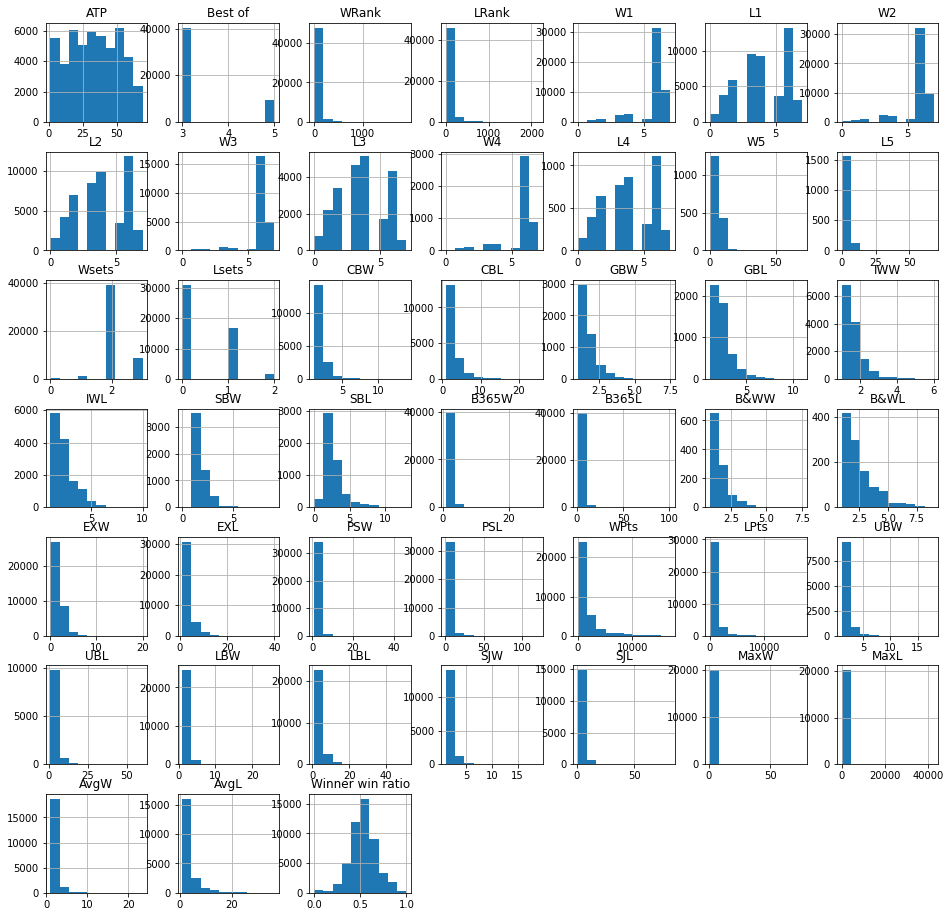

In [14]:
# More details on the values distribution for each feature
hist = df_atp.hist(bins=10, figsize=(16, 16))

Looking at each the description table and the feature distribution with their associated range values histograms above, we can spot the 4 extreme values are: 
- **70** and **68** games won during 5th set
- **42586** and **42136** for max loser odds

----------------

In [15]:
df_atp.loc[df_atp['W5']==70][['Winner', 'Loser', 'W5', 'L5']]

,Winner,Loser,W5,L5
30132,Isner J.,Mahut N.,70.0,68.0


The extreme values of **70** vs **68** games during 5 sets are real values and not buggy ones. Actually, this was the longest tennis match ever!

This match opposed Mahut N. vs Isner J.: https://fr.wikipedia.org/wiki/Match_Isner_-_Mahut_lors_du_tournoi_de_Wimbledon_2010

-------------

When exploring the dataset regarding the **MaxL** extreme values, we made 2 observations:
- 1) Those values are incorrect regarding the available odds of the associated match
- 2) **MaxW**, **MaxL**, **AvgW**, **AvgL** feature can be NaN even if there are available odds associated to the match 

In [16]:
df_atp.loc[df_atp['MaxL']==42586][['Winner', 'Loser', 'B365L', 'EXL', 'PSL', 'LBL', 'MaxL']]

,Winner,Loser,B365L,EXL,PSL,LBL,MaxL
46527,Thiem D.,Millman J.,4.33,3.5,4.77,4.33,42586.0


In [17]:
df_atp.loc[df_atp['MaxL']==42136][['Winner', 'Loser', 'B365L', 'EXL', 'PSL', 'LBL', 'MaxL']]

,Winner,Loser,B365L,EXL,PSL,LBL,MaxL
43332,Nadal R.,Bellucci T.,11.0,8.5,12.5,9.0,42136.0


In [18]:
df_atp.loc[10_000][['B365W', 'B365L', 'MaxW', 'MaxL', 'AvgW', 'AvgL']]

B365W    1.364
B365L    2.875
MaxW       NaN
MaxL       NaN
AvgW       NaN
AvgL       NaN
Name: 10000, dtype: object

Regarding the 2 first examples above, **MaxL** should be respectively 4.77 and 12.5.

The last example shows that there are missing values. We propose to fix those missing values simply by computing them.

In [19]:
winner_odds_columns = ['CBW', 'GBW', 'IWW', 'SBW', 'B365W', 'B&WW', 'EXW', 'PSW', 'UBW', 'LBW', 'SJW']
loser_odds_columns = ['CBL', 'GBL', 'IWL', 'SBL', 'B365L', 'B&WL', 'EXL', 'PSL', 'UBL', 'LBL', 'SJL']

def max_odd_winner(x):
    max_odd = np.nanmax([x[odd] for odd in winner_odds_columns])
    return max_odd

def avg_odd_winner(x):
    avg_odd = np.nanmean([x[odd] for odd in winner_odds_columns])
    return avg_odd

def max_odd_loser(x):
    max_odd = np.nanmax([x[odd] for odd in loser_odds_columns])
    return max_odd

def avg_odd_loser(x):
    avg_odd = np.nanmean([x[odd] for odd in loser_odds_columns])
    return avg_odd


df_atp['MaxW'] = df_atp.apply(lambda x: max_odd_winner(x), axis=1)
df_atp['AvgW'] = df_atp.apply(lambda x: avg_odd_winner(x), axis=1)

df_atp['MaxL'] = df_atp.apply(lambda x: max_odd_loser(x), axis=1)
df_atp['AvgL'] = df_atp.apply(lambda x: avg_odd_loser(x), axis=1)

/Users/matyasamrouche/Documents/Entretiens/Javaness/javaness_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: All-NaN axis encountered
  """
/Users/matyasamrouche/Documents/Entretiens/Javaness/javaness_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/Users/matyasamrouche/Documents/Entretiens/Javaness/javaness_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: All-NaN axis encountered
  del sys.path[0]
/Users/matyasamrouche/Documents/Entretiens/Javaness/javaness_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


In [20]:
df_atp.loc[10_000][['B365W', 'B365L', 'MaxW', 'MaxL', 'AvgW', 'AvgL']]

B365W      1.364
B365L      2.875
MaxW       1.364
MaxL        3.35
AvgW      1.2875
AvgL     3.19375
Name: 10000, dtype: object

In [21]:
# Checking outliers
df_atp.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ATP,49663.0,33.192679,18.092413,1.0000,19.0000,33.00000,49.0000,69.0
Best of,49663.0,3.371705,0.777983,3.0000,3.0000,3.00000,3.0000,5.0
WRank,49647.0,59.119544,73.640935,1.0000,17.0000,41.00000,77.0000,1890.0
LRank,49559.0,92.466373,117.123204,1.0000,35.0000,65.00000,105.0000,2159.0
W1,49415.0,5.793929,1.238380,0.0000,6.0000,6.00000,6.0000,7.0
L1,49416.0,4.048203,1.847254,0.0000,3.0000,4.00000,6.0000,7.0
W2,48919.0,5.773299,1.255283,0.0000,6.0000,6.00000,6.0000,7.0
L2,48920.0,3.864289,1.876281,0.0000,2.0000,4.00000,6.0000,7.0
W3,22774.0,6.020550,0.935368,0.0000,6.0000,6.00000,6.0000,7.0
L3,22774.0,3.596382,1.766727,0.0000,2.0000,4.00000,5.0000,7.0


No more NaN or miscalculated values when odds data are available.

##### Randomization of dataset

In this section, we build an intermediary datasets in order to remove the inherent bias present in the original dataset regarding the Winner and Loser of the match. 

We shuffle and randomized the player associated features (like 'WRank', 'Winner', 'LRank...) that contains an informative for.

In [22]:
def randomize_features(match_data, player_1_data, player_2_data):
    """
    Randomly distribute the winner's and loser's data in player 1 and player 2.
    
    Inputs 
    --------
    match_data : dict :
    player_1_data : dict :
    player_2_data : dict :
    
    Returns 
    --------
    new_features : dict : randomly distributed features row
    """
    new_features = {'atp': match_data['atp'], 'location': match_data['location'], 'tournament': match_data['tournament'],
                    'date': match_data['date'], 'series': match_data['series'], 'court': match_data['court'], 
                    'surface': match_data['surface'], 'round': match_data['round'], 'best_of': match_data['best_of'],
                    'player_1':  player_1_data['name'], 'player_2':  player_2_data['name'], 
                    'player_1_rank':  player_1_data['rank'], 'player_2_rank':  player_2_data['rank'],
                    'player_1_1':  player_1_data['1'], 'player_2_1':  player_2_data['1'],
                    'player_1_2':  player_1_data['3'], 'player_2_2':  player_2_data['2'],
                    'player_1_3':  player_1_data['3'], 'player_2_3':  player_2_data['3'],
                    'player_1_4':  player_1_data['4'], 'player_2_4':  player_2_data['4'],
                    'player_1_5':  player_1_data['5'], 'player_2_5':  player_2_data['5'],
                    'player_1_sets':  player_1_data['sets'], 'player_2_sets':  player_2_data['sets'],
                    'player_1_CB':  player_1_data['CB'], 'player_2_CB':  player_2_data['CB'],
                    'player_1_GB':  player_1_data['GB'], 'player_2_GB':  player_2_data['GB'],
                    'player_1_IW':  player_1_data['IW'], 'player_2_IW':  player_2_data['IW'],
                    'player_1_SB':  player_1_data['SB'], 'player_2_SB':  player_2_data['SB'],
                    'player_1_B365':  player_1_data['B365'], 'player_2_B365':  player_2_data['B365'],
                    'player_1_B&W':  player_1_data['B&W'], 'player_2_B&W':  player_2_data['B&W'],
                    'player_1_EX':  player_1_data['EX'], 'player_2_EX':  player_2_data['EX'],
                    'player_1_PS':  player_1_data['PS'], 'player_2_PS':  player_2_data['PS'],
                    'player_1_Pts':  player_1_data['pts'], 'player_2_Pts':  player_2_data['pts'],
                    'player_1_UB':  player_1_data['UB'], 'player_2_UB':  player_2_data['UB'],
                    'player_1_LB':  player_1_data['LB'], 'player_2_LB':  player_2_data['LB'],
                    'player_1_SJ':  player_1_data['SJ'], 'player_2_SJ':  player_2_data['SJ'],
                    'player_1_Max':  player_1_data['Max'], 'player_2_Max':  player_2_data['Max'],
                    'player_1_Avg':  player_1_data['Avg'], 'player_2_Avg':  player_2_data['Avg'],
                    'outcome': match_data['outcome']}
    
    return new_features


def build_random_dataset(df_atp):
    """
    Iteratively shuffle all row of the original df_atp dataset in order to prevent our learning of a bias such as
    the outcome is always in the Winner column.
    
    Inputs 
    --------
    df_atp : DataFrame : original dataframe
    
    Returns 
    --------
    df_random_player_attribution : DataFrame : randomized dataframe
    """
    all_data = []
    for index, row in tqdm(df_atp.iterrows(), total=df_atp.shape[0]):
        match_data = {'atp': row['ATP'], 'location': row['Location'], 'tournament': row['Tournament'], 
                      'date': row['Date'], 'series': row['Series'], 'court': row['Court'], 'surface': row['Surface'],
                      'round': row['Round'], 'best_of': row['Best of']}

        winner_stats = {'rank': row['WRank'], 'name': row['Winner'], '1': row['W1'], '2': row['W2'], '3': row['W3'], '4': row['W4'],
                        '5': row['W5'], 'sets': row['Wsets'], 'CB': row['CBW'], 'GB': row['GBW'], 'IW': row['IWW'],
                        'SB': row['SBW'], 'B365': row['B365W'], 'B&W': row['B&WW'], 'EX': row['EXW'], 'PS': row['PSW'],
                        'UB': row['UBW'], 'LB': row['LBW'], 'SJ': row['SJW'], 'pts': row['WPts'], 'Max': row['MaxW'],
                        'Avg': row['AvgW']}

        loser_stats = {'rank': row['LRank'], 'name': row['Loser'], '1': row['L1'], '2': row['L2'], '3': row['L3'], '4': row['L4'],
                       '5': row['L5'], 'sets': row['Lsets'], 'CB': row['CBL'], 'GB': row['GBL'], 'IW': row['IWL'],
                       'SB': row['SBL'], 'B365': row['B365L'], 'B&W': row['B&WL'], 'EX': row['EXL'], 'PS': row['PSL'],
                       'UB': row['UBL'], 'LB': row['LBL'], 'SJ': row['SJL'], 'pts': row['LPts'], 'Max': row['MaxL'],
                       'Avg': row['AvgL']}

        random_player_attribution = random.randint(0, 1)
        if random_player_attribution == 0: # winner == player_1
            match_data['outcome'] = 1
            new_row = randomize_features(match_data, winner_stats, loser_stats)
        else: # winner == player_2   
            match_data['outcome'] = 0
            new_row = randomize_features(match_data, loser_stats, winner_stats)

        all_data.append(new_row)   

    df_random_player_attribution = pd.DataFrame(all_data)
    
    return df_random_player_attribution


df_random_player_attribution = build_random_dataset(df_atp)


  0%|          | 0/49663 [00:00<?, ?it/s]

##### Categorical Encoding & Features Engineering 

In this section we engineer the features that will be used by our model to predict Tennis' matchs outcomes.

**Encoding Categorical Features**:

We encode **categorical features** using a target encoding approaches, using the player past win rate associated to each categorical feature. The idea behind this target encoding approach is that players have preferences regarding the type of surface (Nadal R. at Roland Garros), the tournament played, the round of the tournament (Gasquet R. has issue to win after 1/4 final, might be due to psycholigical pression)...
For example, for the match opposing Nadal .R to XXXX in 20..... at Roland Garros, we transformed instead.


**Features Engineering**:
- **Statistical features** from player's gameplay at different window range. Suche features, like the global past win rate, the last 5/10/20 matchs win rate, or the last 5/10/20 average games won, gave us information about the global shape of the player, his more recent shape, his degree of fatigue...
- **Odds features** can be interpreted as external tennis match predictors' outputs, giving us an idea of the "more likely" winning player. Besides, those information are available before the matchs so we can directly use the odds associated to a match to help us predict the current match outcome.



We chose to take the **difference** between the stats of our 2 players (`diff_rank = player_1_rank - player_2_rank`), rather than each statistic indicidually. Indeed, such a symmetry allows our model not to rely on some undesired biases that might be present in the data regarding player 1 vs player 2 data distribution. On top of that, when comparing two statistics, their difference is in general a sufficient informative measure. Besides, it halves our number of features to consider.

--------

Below, we give an exhaustive list of the encoded categorical and engineered features.

Here are the encoded categorical features:
- **diff_location_win_rate**: difference between player 1 and player 2 past win rate associated to the match's location.
- **diff_tournament_win_rate**: difference between player 1 and player 2 past win rate associated to the match's tournament.
- **diff_series_win_rate**: difference between player 1 and player 2 past win rate associated to the match's Serie
- **diff_court_win_rate**: difference between player 1 and player 2 past win rate associated to the match's type of court.
- **diff_surface_win_rate**: difference between player 1 and player 2 past win rate associated to the match's type surface.
- **diff_best_of_win_rate**: difference between player 1 and player 2 past win rate associated to the match's best of.

Here are the players statistics engineered features:
- **diff_rank**: difference between player 1 and player 2 ranks at the moment of the match.
- **diff_Pts**: difference between player 1 and player 2 ATP points at the moment of the match.
- **diff_global_win_rate**: difference between player 1 and player 2 past win rate at the match's court
- **diff_past_5_win_rate**: difference between player 1 and player 2 past 5 matchs win rate at the moment of the match.
- **diff_past_10_win_rate**: difference between player 1 and player 2 past 10 matchs win rate at the moment of the match.
- **diff_past_20_win_rate**: difference between player 1 and player 2 past 20 matchs win rate at the moment of the match.
- **diff_global_avg_games_won_first_set**: difference between player 1 and player 2 past average games won during the first set.
- **diff_past_5_avg_games_won_first_set**: difference between player 1 and player 2 past 5 matchs average games won during the first set.
- **diff_past_10_avg_games_won_first_set**: difference between player 1 and player 2 past 10 matchs average games won during the first set.
- **diff_past_20_avg_games_won_first_set**: difference between player 1 and player 2 past 20 matchs average games won during the first set.
- **diff_global_avg_games_won_second_set**: difference between player 1 and player 2 past average games won during the second set.
- **diff_past_5_avg_games_won_second_set**: difference between player 1 and player 2 past 5 matchs average games won during the second set.
- **diff_past_10_avg_games_won_second_set**: difference between player 1 and player 2 past 10 matchs average games won during the second set.
- **diff_past_20_avg_games_won_second_set**: difference between player 1 and player 2 past 20 matchs average games won during the second set.
- **diff_global_avg_games_won_third_set**: difference between player 1 and player 2 past average games won during the third set.
- **diff_past_5_avg_games_won_third_set**: difference between player 1 and player 2 past 5 matchs average games won during the third set.
- **diff_past_10_avg_games_won_third_set**: difference between player 1 and player 2 past 10 matchs average games won during the third set.
- **diff_past_20_avg_games_won_third_set**: difference between player 1 and player 2 past 20 matchs average games won during the third set.
- **diff_global_avg_games_won_fourth_set**: difference between player 1 and player 2 past average games won during the fourth set.
- **diff_past_5_avg_games_won_fourth_set**: difference between player 1 and player 2 past 5 matchs average games won during the fourth set.
- **diff_past_10_avg_games_won_fourth_set**: difference between player 1 and player 2 past 10 matchs average games won during the fourth set.
- **diff_past_20_avg_games_won_fourth_set**: difference between player 1 and player 2 past 20 matchs average games won during the fourth set.
- **diff_global_avg_games_won_fifth_set**: difference between player 1 and player 2 past average games won during the fifth set.
- **diff_past_5_avg_games_won_fifth_set**: difference between player 1 and player 2 past 5 matchs average games won during the fifth set.
- **diff_past_10_avg_games_won_fifth_set**: difference between player 1 and player 2 past 10 matchs average games won during the fifth set.
- **diff_past_20_avg_games_won_fifth_set**: difference between player 1 and player 2 past 20 matchs average games won during the fifth set.
- **diff_global_past_avg_won_sets**: difference between player 1 and player 2 past avergae won sets.
- **diff_past_5_avg_won_sets**: difference between player 1 and player 2 past 5 matchs avergae won sets.
- **diff_past_10_avg_won_sets**: difference between player 1 and player 2 past 10 matchs avergae won sets.
- **diff_past_20_avg_won_sets**: difference between player 1 and player 2 past 20 matchs avergae won sets.

Here are the odds engineered features:
- **diff_CB**: difference between player 1 and player 2 odds from CenterBet for the current match.
- **diff_GB**: difference between player 1 and player 2 odds from Gamebookers for the current match.
- **diff_IW**: difference between player 1 and player 2 odds from Interwetten for the current match.
- **diff_SB**: difference between player 1 and player 2 odds from Sportingbet for the current match.
- **diff_B365**: difference between player 1 and player 2 odds from Bet365 for the current match.
- **diff_B&W**: difference between player 1 and player 2 odds from Bet&Win for the current match.
- **diff_EX**: difference between player 1 and player 2 odds from Expekt for the current match.
- **diff_PS**: difference between player 1 and player 2 odds from Pinnacles for the current match.
- **diff_UB**: difference between player 1 and player 2 odds from Unibet for the current match.
- **diff_LB**: difference between player 1 and player 2 odds from Ladbrokes for the current match.
- **diff_SJ**: difference between player 1 and player 2 odds from Stan James for the current match.
- **diff_Max**: difference between player 1 and player 2 max odds.
- **diff_Avg**: difference between player 1 and player 2 average odds.


-------

The main function of this section `build_dataset()` is quite heavy to read given the number of computed features but eady to understand. 

Here is a description of what it does:

1/ **Initialise** caches for all the player and their associated stats

2/ For all matchs in the dataset with respect to their chronological order:
- **Get** the stats of the past match's players stats (takes O(1) given caches are dict) and some of the current match statistics that does not leak future information (like players' rank, players' points, betting odds).
- **Compute** the engineered features for the current match.
- **Update** the relevant players' caches regarding the current match statistics.


This cache approach allows to efficiently compute (in ~ 30s) the engineered features on all the dataset's matchs. 

In [23]:
df = df_random_player_attribution.copy()

all_players = set(list(df.player_1.unique()) + list(df.player_2.unique()))

# Categorical features caches
list_location = df.location.unique()
location_cache = {player: {location: [0, 0] for location in list_location} for player in all_players}

list_tournament = df.tournament.unique()
tournament_cache = {player: {tournament: [0, 0] for tournament in list_tournament} for player in all_players}

list_series = df.series.unique()
series_cache = {player: {series: [0, 0] for series in list_series} for player in all_players}

list_court = df.court.unique()
court_cache = {player: {court: [0, 0] for court in list_court} for player in all_players}

list_surface = df.surface.unique()
surface_cache = {player: {surface: [0, 0] for surface in list_surface} for player in all_players}

list_round = df['round'].unique()
round_cache = {player: {_round: [0, 0] for _round in list_round} for player in all_players}

list_best_of = df.best_of.unique()
best_of_cache = {player: {best_of: [0, 0] for best_of in list_best_of} for player in all_players}


# Statistical features caches
statistical_win_rate_cache = {player: {'global_win_rate': [0, 0],
                                       'past_5_win_rate': [np.nan for _ in range(5)], 
                                       'past_10_win_rate': [np.nan for _ in range(10)], 
                                       'past_20_win_rate': [np.nan for _ in range(20)]} for player in all_players}

statistical_avg_stats_cache = {player: {'global_avg_games_won_first_set': [0, 0],
                                        'past_5_avg_games_won_first_set': [np.nan for _ in range(5)], 
                                        'past_10_avg_games_won_first_set': [np.nan for _ in range(10)], 
                                        'past_20_avg_games_won_first_set': [np.nan for _ in range(20)], 
                                        
                                        'global_avg_games_won_second_set': [0, 0],
                                        'past_5_avg_games_won_second_set': [np.nan for _ in range(5)], 
                                        'past_10_avg_games_won_second_set': [np.nan for _ in range(10)], 
                                        'past_20_avg_games_won_second_set': [np.nan for _ in range(20)],
                                        
                                        'global_avg_games_won_third_set': [0, 0],
                                        'past_5_avg_games_won_third_set': [np.nan for _ in range(5)], 
                                        'past_10_avg_games_won_third_set': [np.nan for _ in range(10)], 
                                        'past_20_avg_games_won_third_set': [np.nan for _ in range(20)],
                                        
                                        'global_avg_games_won_fourth_set': [0, 0],
                                        'past_5_avg_games_won_fourth_set': [np.nan for _ in range(5)], 
                                        'past_10_avg_games_won_fourth_set': [np.nan for _ in range(10)], 
                                        'past_20_avg_games_won_fourth_set': [np.nan for _ in range(20)],
                                       
                                        'global_avg_games_won_fifth_set': [0, 0],
                                        'past_5_avg_games_won_fifth_set': [np.nan for _ in range(5)], 
                                        'past_10_avg_games_won_fifth_set': [np.nan for _ in range(10)], 
                                        'past_20_avg_games_won_fifth_set': [np.nan for _ in range(20)],
                                       
                                        'global_past_won_sets': [0, 0],
                                        'past_5_won_sets': [np.nan for _ in range(5)], 
                                        'past_10_won_sets': [np.nan for _ in range(10)], 
                                        'past_20_won_sets': [np.nan for _ in range(20)]} for player in all_players}



In [24]:
def compute_diff(cache, player_1, player_2, feature, window):
    """
    Compute the difference between the statistics
    
    Inputs 
    --------
    cache : dict : dataset to normalize
    player_1 : str : player's 1 name
    player_2 : str : player's 2 name
    feature : str : the feature to update
    window : str : either it is a 'global' (all past matchs are considered) or a 'local' (only a limited 
                   number of matchs are considered) feature
    """
    if (window == 'global'):
        if (cache[player_1][feature][1] > 0) and (cache[player_2][feature][1] > 0):
            stat_1 = round(cache[player_1][feature][0] / cache[player_1][feature][1], 4)
            stat_2 = round(cache[player_2][feature][0] / cache[player_2][feature][1], 4) 
        else:
            stat_1 = np.nan
            stat_2 = np.nan
            
    elif (window == 'local'):
        stat_1 = round(sum(cache[player_1][feature]) / len(cache[player_1][feature]), 4)
        stat_2 = round(sum(cache[player_2][feature]) / len(cache[player_2][feature]), 4)  
        
    else:
        raise Exception("Wrong window mode, must be 'global' or 'local'.")
        
    diff = stat_1 - stat_2
    return diff

def update_win_rate_cache(cache, winning_player, loosing_player, feature, window):
    """
    Update the the statistical_win_rate_cache with the current match's outcome.
    
    Inputs 
    --------
    cache : dict : dictionary that keeps track of the 
    winning_player : str : winning player's name
    loosing_player : str : loosing player's name
    feature : str : the feature to update
    window : str : either it is a 'global' (all past matchs are considered) or a 'local' (only a limited 
                   number of matchs are considered) feature
    """
    if (window == 'global'):
        # Add a win and a match to the winning_player counter
        cache[winning_player][feature][0] += 1
        cache[winning_player][feature][1] += 1
        
        # Add a match to the loosing_player counter
        cache[loosing_player][feature][1] += 1
        
    elif (window == 'local'):
        # Add a win to the winning player past window, and pop latest match in the past window
        cache[winning_player][feature].append(1)
        cache[winning_player][feature].pop(0)
        
        # Add a lose to the loosing player past window, and pop latest match in the past window
        cache[loosing_player][feature].append(0)
        cache[loosing_player][feature].pop(0)

    else:
        raise Exception("Wrong window mode, must be 'global' or 'local'.")
                  
def update_avg_stats_cache(cache, winning_player, loosing_player, winner_stats, looser_stats, feature, window):
    """
    Update the the statistical_avg_stats_cache with the current match's stats.
    
    Inputs 
    --------
    cache : dict : dictionary that keeps track of the 
    winning_player : str : winning player's name
    loosing_player : str : loosing player's name
    winner_stats : float : 
    looser_stats : float
    feature : str : the feature to update
    window : str : either it is a 'global' (all past matchs are considered) or a 'local' (only a limited 
                   number of matchs are considered) feature
    """
    #print(winner_stats, looser_stats)
    #print(np.isnan(winner_stats))
    #print(np.isnan(looser_stats))
    #print((np.isnan(winner_stats)) and (np.isnan(looser_stats)))
    #print()
    # Check if the match stats are not NaN
    if (not np.isnan(winner_stats)) and (not np.isnan(looser_stats)):
        
        if (window == 'global'):
            # Add the winner stats to the sum of the desired statis and a match to the winning_player counter
            cache[winning_player][feature][0] += winner_stats
            cache[winning_player][feature][1] += 1

            # Add a match to the loosing_player counter
            cache[winning_player][feature][0] += looser_stats
            cache[loosing_player][feature][1] += 1

        elif (window == 'local'):
            # Add the winner stats to list of past winning stats, and pop latest match stats in the past window
            cache[winning_player][feature].append(winner_stats)
            cache[winning_player][feature].pop(0)

            # Add a lose to the loosing player past window, and pop latest match stats in the past window
            cache[loosing_player][feature].append(looser_stats)
            cache[loosing_player][feature].pop(0)

        else:
            raise Exception("Wrong window mode, must be 'global' or 'local'.")

def build_dataset(df):
    """
    Incrementaly build the engineered features dataset using cached data for speed efficiency.
    
    Inputs 
    --------
    df : DataFrame : 
    
    Returns 
    --------
    dataset : DataFrame : engineered features dataset 
    """
    all_data = []

    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        player_1 = row['player_1']
        player_2 = row['player_2'] 

        location = row['location']
        tournament = row['tournament']
        series = row['series']
        court = row['court']
        surface = row['surface']
        _round = row['round']
        best_of = row['best_of']

        outcome = row['outcome']

        ################################
        ##### FEATURES ENGINEERING #####
        ################################ 
        featured_row = {}

        featured_row['date'] = row['date']
        featured_row['player_1'] = player_1
        featured_row['player_2'] = player_2

        # Categorical encoded features
        featured_row['diff_location_win_rate'] = compute_diff(location_cache, player_1, player_2, location, window='global')
        featured_row['diff_tournament_win_rate'] = compute_diff(tournament_cache, player_1, player_2, tournament, window='global')
        featured_row['diff_series_win_rate'] = compute_diff(series_cache, player_1, player_2, series, window='global')
        featured_row['diff_court_win_rate'] = compute_diff(court_cache, player_1, player_2, court, window='global')
        featured_row['diff_surface_win_rate'] = compute_diff(surface_cache, player_1, player_2, surface, window='global')
        featured_row['diff_round_win_rate'] = compute_diff(round_cache, player_1, player_2, _round, window='global')
        featured_row['diff_best_of_win_rate'] = compute_diff(best_of_cache, player_1, player_2, best_of, window='global')

        # Tennis statistical features
        featured_row['diff_rank'] = row['player_1_rank'] - row['player_2_rank']
        featured_row['diff_Pts'] = row['player_1_Pts'] - row['player_2_Pts']

        featured_row['diff_global_win_rate'] = compute_diff(statistical_win_rate_cache, player_1, player_2, 'global_win_rate', window='global')
        featured_row['diff_past_5_win_rate'] = compute_diff(statistical_win_rate_cache, player_1, player_2, 'past_5_win_rate', window='local')
        featured_row['diff_past_10_win_rate'] = compute_diff(statistical_win_rate_cache, player_1, player_2, 'past_10_win_rate', window='local')
        featured_row['diff_past_20_win_rate'] = compute_diff(statistical_win_rate_cache, player_1, player_2, 'past_20_win_rate', window='local')

        featured_row['diff_global_avg_games_won_first_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'global_avg_games_won_first_set', window='global')
        featured_row['diff_past_5_avg_games_won_first_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'past_5_avg_games_won_first_set', window='local')
        featured_row['diff_past_10_avg_games_won_first_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'past_10_avg_games_won_first_set', window='local')
        featured_row['diff_past_20_avg_games_won_first_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'past_20_avg_games_won_first_set', window='local')

        featured_row['diff_global_avg_games_won_second_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'global_avg_games_won_second_set', window='global')
        featured_row['diff_past_5_avg_games_won_second_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'past_5_avg_games_won_second_set', window='local')
        featured_row['diff_past_10_avg_games_won_second_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'past_10_avg_games_won_second_set', window='local')
        featured_row['diff_past_20_avg_games_won_second_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'past_20_avg_games_won_second_set', window='local')

        featured_row['diff_global_avg_games_won_third_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'global_avg_games_won_third_set', window='global')
        featured_row['diff_past_5_avg_games_won_third_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'past_5_avg_games_won_third_set', window='local')
        featured_row['diff_past_10_avg_games_won_third_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'past_10_avg_games_won_third_set', window='local')
        featured_row['diff_past_20_avg_games_won_third_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'past_20_avg_games_won_third_set', window='local')

        featured_row['diff_global_avg_games_won_fourth_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'global_avg_games_won_fourth_set', window='global')
        featured_row['diff_past_5_avg_games_won_fourth_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'past_5_avg_games_won_fourth_set', window='local')
        featured_row['diff_past_10_avg_games_won_fourth_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'past_10_avg_games_won_fourth_set', window='local')
        featured_row['diff_past_20_avg_games_won_fourth_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'past_20_avg_games_won_fourth_set', window='local')

        featured_row['diff_global_avg_games_won_fifth_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'global_avg_games_won_fifth_set', window='global')
        featured_row['diff_past_5_avg_games_won_fifth_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'past_5_avg_games_won_fifth_set', window='local')
        featured_row['diff_past_10_avg_games_won_fifth_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'past_10_avg_games_won_fifth_set', window='local')
        featured_row['diff_past_20_avg_games_won_fifth_set'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'past_20_avg_games_won_fifth_set', window='local')

        featured_row['diff_global_past_won_sets'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'global_past_won_sets', window='global')
        featured_row['diff_past_5_won_sets'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'past_5_won_sets', window='local')
        featured_row['diff_past_10_won_sets'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'past_10_won_sets', window='local')
        featured_row['diff_past_20_won_sets'] = compute_diff(statistical_avg_stats_cache, player_1, player_2, 'past_20_won_sets', window='local')

        # Odds features
        featured_row['diff_CB'] = row['player_1_CB'] - row['player_2_rank']
        featured_row['diff_GB'] = row['player_1_GB'] - row['player_2_GB']
        featured_row['diff_IW'] = row['player_1_IW'] - row['player_2_IW']
        featured_row['diff_SB'] = row['player_1_SB'] - row['player_2_SB']
        featured_row['diff_B365'] = row['player_1_B365'] - row['player_2_B365']
        featured_row['diff_B&W'] = row['player_1_B&W'] - row['player_2_B&W']
        featured_row['diff_EX'] = row['player_1_EX'] - row['player_2_EX']
        featured_row['diff_PS'] = row['player_1_PS'] - row['player_2_PS']
        featured_row['diff_UB'] = row['player_1_UB'] - row['player_2_UB']
        featured_row['diff_LB'] = row['player_1_LB'] - row['player_2_LB']
        featured_row['diff_SJ'] = row['player_1_SJ'] - row['player_2_SJ']
        featured_row['diff_Max'] = row['player_1_Max'] - row['player_2_Max']
        featured_row['diff_Avg'] = row['player_1_Avg'] - row['player_2_Avg']

        # Outcome
        featured_row['outcome'] = row['outcome']

        # Add all the engineered data 
        all_data.append(featured_row)

        ########################
        ##### UPDATE CACHE #####
        ########################
        # player 1 won
        if outcome == 1:
            winning_player = player_1
            winner_games_1 = row['player_1_1']
            winner_games_2 = row['player_1_2']
            winner_games_3 = row['player_1_3']
            winner_games_4 = row['player_1_4']
            winner_games_5 = row['player_1_5']
            winner_sets = row['player_1_sets']


            loosing_player = player_2
            looser_games_1 = row['player_2_1']
            looser_games_2 = row['player_2_2']
            looser_games_3 = row['player_2_3']
            looser_games_4 = row['player_2_4']
            looser_games_5 = row['player_2_5']
            looser_sets = row['player_2_sets']

        # player 2 won 
        else:
            winning_player = player_2
            winner_games_1 = row['player_2_1']
            winner_games_2 = row['player_2_2']
            winner_games_3 = row['player_2_3']
            winner_games_4 = row['player_2_4']
            winner_games_5 = row['player_2_5']
            winner_sets = row['player_2_sets']

            loosing_player = player_1
            looser_games_1 = row['player_1_1']
            looser_games_2 = row['player_1_2']
            looser_games_3 = row['player_1_3']
            looser_games_4 = row['player_1_4']
            looser_games_5 = row['player_1_5']
            looser_sets = row['player_1_sets']

        # Update the caches regarding the outcome of the current match
        update_win_rate_cache(location_cache, winning_player, loosing_player, location, window='global')
        update_win_rate_cache(tournament_cache, winning_player, loosing_player, tournament, window='global')
        update_win_rate_cache(series_cache, winning_player, loosing_player, series, window='global')
        update_win_rate_cache(court_cache, winning_player, loosing_player, court, window='global')
        update_win_rate_cache(surface_cache, winning_player, loosing_player, surface, window='global')
        update_win_rate_cache(round_cache, winning_player, loosing_player, _round, window='global')
        update_win_rate_cache(best_of_cache, winning_player, loosing_player, best_of, window='global')

        update_win_rate_cache(statistical_win_rate_cache, winning_player, loosing_player, 'global_win_rate', window='global')
        update_win_rate_cache(statistical_win_rate_cache, winning_player, loosing_player, 'past_5_win_rate', window='local')
        update_win_rate_cache(statistical_win_rate_cache, winning_player, loosing_player, 'past_10_win_rate', window='local')
        update_win_rate_cache(statistical_win_rate_cache, winning_player, loosing_player, 'past_20_win_rate', window='local')

        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_1, looser_games_1, 'global_avg_games_won_first_set', window='global')
        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_1, looser_games_1, 'past_5_avg_games_won_first_set', window='local')
        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_1, looser_games_1, 'past_10_avg_games_won_first_set', window='local')
        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_1, looser_games_1, 'past_20_avg_games_won_first_set', window='local')

        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_2, looser_games_2, 'global_avg_games_won_second_set', window='global')
        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_2, looser_games_2, 'past_5_avg_games_won_second_set', window='local')
        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_2, looser_games_2, 'past_10_avg_games_won_second_set', window='local')
        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_2, looser_games_2, 'past_20_avg_games_won_second_set', window='local')

        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_3, looser_games_3, 'global_avg_games_won_third_set', window='global')
        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_3, looser_games_3, 'past_5_avg_games_won_third_set', window='local')
        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_3, looser_games_3, 'past_10_avg_games_won_third_set', window='local')
        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_3, looser_games_3, 'past_20_avg_games_won_third_set', window='local')

        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_4, looser_games_4, 'global_avg_games_won_fourth_set', window='global')
        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_4, looser_games_4, 'past_5_avg_games_won_fourth_set', window='local')
        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_4, looser_games_4, 'past_10_avg_games_won_fourth_set', window='local')
        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_4, looser_games_4, 'past_20_avg_games_won_fourth_set', window='local')

        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_5, looser_games_5, 'global_avg_games_won_fifth_set', window='global')
        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_5, looser_games_5, 'past_5_avg_games_won_fifth_set', window='local')
        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_5, looser_games_5, 'past_10_avg_games_won_fifth_set', window='local')
        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_games_5, looser_games_5, 'past_20_avg_games_won_fifth_set', window='local')

        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_sets, looser_sets, 'global_past_won_sets', window='global')
        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_sets, looser_sets, 'past_5_won_sets', window='local')
        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_sets, looser_sets, 'past_10_won_sets', window='local')
        update_avg_stats_cache(statistical_avg_stats_cache, winning_player, loosing_player, winner_sets, looser_sets, 'past_20_won_sets', window='local')
    
    # Create dataset
    dataset = pd.DataFrame(all_data)
    
    return dataset
    

In [25]:
dataset = build_dataset(df)

  0%|          | 0/49663 [00:00<?, ?it/s]

In [26]:
dataset['outcome'].describe()

count    49663.000000
mean         0.499305
std          0.500005
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: outcome, dtype: float64

We observe a balance outcome class, meaning there are as many winning player_1 as winning player_2.

**Accuracy** will be a sufficient metric to evaluate our models's performance. 

##### Data Normalization with respect to dataset timeline

Our last processing step is to normalize our data in order to keep our features' values in a comparable range.

In order to remain coherent with the timeline of the data, we normalize the data regarding the values seen during training in order to prevent a data leak from future information.

In [27]:
def normalize_dataset(dataset, evaluation_year):
    """
    Normalize dataset features in 0 to 1 range regarding the statistics computed strictly before the specified 
    evaluation year in order to prevent future data leaking.
    
    Inputs 
    --------
    dataset : DataFrame : dataset to normalize
    max_year : int : max year to consider to perform the normalization
    
    Returns 
    --------
    normalized_dataset : DataFrame : normalized dataset computed with the statistics before the evaluation year.
    """
    date = f'{evaluation_year}-01-01 00:00:00'
    dataset_before_date = dataset.loc[dataset['date'] < Timestamp(date)]
    data_before_date = dataset_before_date.loc[:, (~dataset_before_date.columns.isin(['date', 'player_1', 'player_2']))]
    
    data_min = data_before_date.min()
    data_max = data_before_date.max()
    data = dataset.loc[:, (~dataset.columns.isin(['date', 'player_1', 'player_2']))]
    
    normalized_data = (data - data_min) / (data_max - data_min)
    
    return normalized_data

In [28]:
# Normalize data 
normalize_data_2017 = normalize_dataset(dataset, evaluation_year=2017)
normalize_data_2016 = normalize_dataset(dataset, evaluation_year=2016)

In [29]:
# Due to our random player attribution, in order to reproduce notebook best obtained results
# Uncomment the following lines and load the saved datasets

#normalize_data_2016 = pd.read_csv('normalize_data_2016.csv', index_col=[0])
#normalize_data_2017 = pd.read_csv('normalize_data_2017.csv', index_col=[0])

#### Modeling Phase

In this section we explore 2 approaches to predict the outcome of tennis matchs given the previously engineered features.

In order to respect the timeline of our dataset and to remain as close to the reality as possible, we divide our dataset in Train / Test sets regarding the **date** of the match. Indeed, if training on future data we can expect data leaking, corrupting the parameters learned by the model with future information.

Our Modeling Phase if divided in 2 steps. A **Training/Validation** step for hyperparameters tuning where our model is trained on data from 2000 to end 2015 and validated on 2016. Once our model validated on 2016, during the **Training/Evaluation** step, we retrain it on data from 2000 to end 2016 using the best found configuration and evaluate its performance on data from 2017.

1) A **Training/Validation** step:

- **Train set**: matchs from 2000-2015
- **Validation set**: matchs from 2016

2) A **Training/Evaluation** step:

- **Train set**: matchs from 2000-2016
- **Test set**: matchs from 2017


Given that our outcome class (0 when player 1 looses and 1 when he wins) is balanced, the performance metric that we will consider to evaluate the models' performance will be the **accuracy** of the predictions.

In [30]:
def split_datasets(data, evaluation_year):
    """
    Split the datasets regarding the desired evaluation year (2016 or 2017 in our case).
    
    Inputs 
    --------
    data : DataFrame : data to split
    evaluation_year : int : year to consider to perform the model's evaluation
    
    Returns 
    --------
    train_set : np.ndarray : training dataset
    y_train : np.ndarray : training labels
    test_set : np.ndarray : validation dataset
    y_test : np.ndarray : validation labels
    """
    # Validation on year 2016
    if evaluation_year == 2016:
        evaluation_start_index = 44402   # index location where starts year 2016 in dataframe
        evaluation_end_index = 47028     # index location where ends year 2016 in dataframe
        
    # Final evaluation on year 2017    
    elif evaluation_year == 2017:
        evaluation_start_index = 47028  # index location where starts year 2017 in dataframe
        evaluation_end_index = 49663    # index location where ends year 2017 in dataframe
        
    else:
        raise Exception("Wrong evaluation_year, must be either 2016 or 2017.")
        
    train_indices = np.arange(0, evaluation_start_index)
    train_set = data.drop(['outcome'], axis=1).loc[train_indices].values
    y_train = data['outcome'].loc[train_indices].values
    
    test_indices = np.arange(evaluation_start_index, evaluation_end_index)
    test_set = data.drop(['outcome'], axis=1).loc[test_indices].values
    y_test = data['outcome'].loc[test_indices].values
    
    return train_set, y_train, test_set, y_test


##### Training/Validation Logistic Regression

In this section, we construct a simple baseline Logistic Regression model in order to have a rough baseline to compare our more complex approach.

In [31]:
X_train, y_train, X_val, y_val = split_datasets(normalize_data_2016, evaluation_year=2016)

# Replace NaN values by the column mean value (Logistic Regression can't handle NaN values)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train)
SimpleImputer()

# Logistic Regression model with defaults parameters
logreg_clf = LogisticRegression(solver='liblinear', max_iter=100)
logreg_clf.fit(imp.transform(X_train), y_train)

y_pred_train = logreg_clf.predict(imp.transform(X_train))
accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
print("Training Accuracy:", accuracy_train)

y_pred_val = logreg_clf.predict(imp.transform(X_val))
accuracy_val = round(accuracy_score(y_val, y_pred_val), 4)
print("Validation Accuracy:", accuracy_val)

Training Accuracy: 0.6908
Validation Accuracy: 0.7018


##### Training/Validation XGBoost

For our more complex appraoch, we chose a Gradient Boosting algorithm. We used an open-source model XGBoost which have shown great results on different sets of structured datasets.

In [32]:
def train_xgb(X_train, y_train, X_val, y_val, kwargs):
    """
    Train XGBClassifier model on X_train and validate on X_val.
    
    Inputs 
    --------
    X_train : np.ndarray : training dataset
    y_train : np.ndarray : training labels
    X_val : np.ndarray : validation dataset
    y_val : np.ndarray : validation labels
    kwargs : dict : data to split
    
    Returns 
    --------
    lgb_clf : XGBClassifier : trained XGBClassifier on X_train
    accuracy_val : float : the accuracy obtained on the validation set 
    """
    ########################
    ####### Training #######
    ######################## 
    xgb_clf = xgb.XGBClassifier(**kwargs)
    xgb_clf.fit(X_train, y_train)
    
    y_pred_train = xgb_clf.predict(X_train)
    accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
    
    ########################
    ###### Validation ######
    ########################
    y_pred_val = xgb_clf.predict(X_val)
    accuracy_val = round(accuracy_score(y_val, y_pred_val), 4)
    
    print("")
    print("Parameters:", kwargs)
    print("Training Accuracy:", accuracy_train)
    print("Validation Accuracy:", accuracy_val)
    print("")
    
    return xgb_clf, accuracy_val


def tune_hyperparameters(X_train, y_train, X_val, y_val, n_iterations):
    """
    Perform a random search to tune the hyperparameters of XGBClassifier.
    
    Inputs 
    --------
    X_train : np.ndarray : training dataset
    y_train : np.ndarray : training labels
    X_val : np.ndarray : validation dataset
    y_val : np.ndarray : validation labels
    n_iterations : int : number of iteration to perform the random search 
    
    Returns 
    --------
    best_model : LGBMClassifier : best trained XGBClassifier regarding its validation accuracy
    best_params : dict : best found parameters regarding best_model validation accuracy
    """
    best_accuracy = 0
    for i in range(n_iterations):
        print("")
        print('======== Iteration {:} / {:} ========'.format(i + 1, n_iterations))
        print('Training...')

        kwargs = {'objective': 'binary:logistic',
                  'colsample_bytree': 0.3,                            #
                  'subsample': random.choice([0.7, 1]),               #
                  'max_depth': random.choice([6, 10, 15]),            # depth of weak learner
                  'learning_rate': random.choice([0.1, 0.01, 0.001]), # the influence of weak learner on prediction
                  'n_estimators': random.choice([100, 500, 1000]),    # number of weak learners
                  'alpha': 1,                                         # L2 regulirization term to prevent overfitting
                  'seed': 42}                    
        
        model, accuracy = train_xgb(X_train, y_train, X_val, y_val, kwargs)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_params = kwargs
        
    return best_model, best_params



In [33]:
# The tune_hyperparameters() function was run on 50 iterations to find the following best parameters.

#X_train, y_train, X_val, y_val = split_datasets(normalize_data_2016, evaluation_year=2016)
#best_model, best_params = tune_hyperparameters(X_train, y_train, X_val, y_val, n_iterations=50)

In [34]:
best_params = {'objective': 'binary:logistic',
               'colsample_bytree': 1,
               'subsample': 1,
               'max_depth': 6,
               'learning_rate': 0.01,
               'n_estimators': 500,
               'alpha': 1,
               'seed': 42}


# For the validation step, we use the dataset normalized regarding the evaluation year 2016
X_train, y_train, X_val, y_val = split_datasets(normalize_data_2016, evaluation_year=2016)

# Train on 2000 to 2015 included and Validate on 2016
best_model, best_accuracy = train_xgb(X_train, y_train, X_val, y_val, kwargs=best_params)

/Users/matyasamrouche/Documents/Entretiens/Javaness/javaness_env/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:55:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Parameters: {'objective': 'binary:logistic', 'colsample_bytree': 1, 'subsample': 1, 'max_depth': 6, 'learning_rate': 0.01, 'n_estimators': 500, 'alpha': 1, 'seed': 42}
Training Accuracy: 0.7141
Validation Accuracy: 0.706



In [35]:
# Save model to reproduce results
#pickle.dump(best_model, open("best_model.pkl", "wb"))

In [36]:
# To repoduce results, due to the randomness of tree creation in XGBoost, load the best saved model


#best_model = pickle.load(open("best_model.pkl", "rb"))
#X_train, y_train, X_val, y_val = split_datasets(normalize_data_2016, evaluation_year=2016)
#y_pred_train = best_model.predict(X_train)
#accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
#y_pred_val = best_model.predict(X_val)
#accuracy_val = round(accuracy_score(y_val, y_pred_val), 4)

#print("Training Accuracy:", accuracy_train)
#print("Validation Accuracy:", accuracy_val)"""

'best_model = pickle.load(open("best_model.pkl", "rb"))\n\nX_train, y_train, X_val, y_val = split_datasets(normalize_data_2016, evaluation_year=2016)\n\ny_pred_train = best_model.predict(X_train)\naccuracy_train = round(accuracy_score(y_train, y_pred_train), 4)\n\ny_pred_val = best_model.predict(X_val)\naccuracy_val = round(accuracy_score(y_val, y_pred_val), 4)\n\nprint("Training Accuracy:", accuracy_train)\nprint("Validation Accuracy:", accuracy_val)'

The XGBClassifier is able to reach a higher accuracy (on average over all our different runs) on the validation dataset than our simple Logistic Regression approach. On top of that, Logistic Regression can't handle missing values and need replacement values, which can be source of bias for our model.

Besides, given that the training accuracy is quite close to the validation and setting a L2 regularization parameter we can expect a model robust to overfitting and able to generalize well.

**We select the XGBClassifier as our final model.**

##### Training/Evaluation on Test set

For the final Evaluation **predicting the matchs' outcomes of year 2017**, we retrain our LighGBM model on the data from 2000 to 2016 (2016 included this time) using the best hyperparameters found during the previous Validation phase.

In [37]:
# For the final evaluation, we use the dataset normalized regarding the evaluation year 2017
X_train, y_train, X_test, y_test = split_datasets(normalize_data_2017, evaluation_year=2017)

# Train on 2000 to 2016 included and Test on 2017
final_model, final_accuracy = train_xgb(X_train, y_train, X_test, y_test, kwargs=best_params)

/Users/matyasamrouche/Documents/Entretiens/Javaness/javaness_env/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:56:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Parameters: {'objective': 'binary:logistic', 'colsample_bytree': 1, 'subsample': 1, 'max_depth': 6, 'learning_rate': 0.01, 'n_estimators': 500, 'alpha': 1, 'seed': 42}
Training Accuracy: 0.713
Validation Accuracy: 0.6793



In [38]:
# Save model to reproduce results
#pickle.dump(final_model, open("final_model.pkl", "wb"))

In [39]:
# To repoduce best results uncoment the following lines


#final_model = pickle.load(open("final_model.pkl", "rb"))

#X_train, y_train, X_test, y_test = split_datasets(normalize_data_2017, evaluation_year=2017)

#y_pred_train = final_model.predict(X_train)
#accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)

#y_pred_test = final_model.predict(X_test)
#accuracy_test = round(accuracy_score(y_test, y_pred_test), 4)

#print("Training Accuracy:", accuracy_train)
#print("Validation Accuracy:", accuracy_test)


'final_model = pickle.load(open("final_model.pkl", "rb"))\n\nX_train, y_train, X_test, y_test = split_datasets(normalize_data_2017, evaluation_year=2017)\n\ny_pred_train = final_model.predict(X_train)\naccuracy_train = round(accuracy_score(y_train, y_pred_train), 4)\n\ny_pred_test = final_model.predict(X_test)\naccuracy_test = round(accuracy_score(y_test, y_pred_test), 4)\n\nprint("Training Accuracy:", accuracy_train)\nprint("Validation Accuracy:", accuracy_test)'

**Our final model would have predicted the Tennis matchs' outcome of 2017 with 68% accuracy.**

#### Observation/Explanation

In this section, we inspect the most important discriminative features and erros of our model.

Given that we want to use our final model prediction's for a betting strategy on 2017 matchs, we focus on the results of our best model trained on data from 2000 to end 2015 and validated on 2016 in order to simulate a real life situation. Indeed, by following this approach, the found results won't be corrupted by leaking information from year 2017. 

In [40]:
X_train, y_train, X_val, y_val = split_datasets(normalize_data_2016, evaluation_year=2016)


##### Features Importance

Text(0.5, 1.0, 'LightGBM Features (avg over folds)')

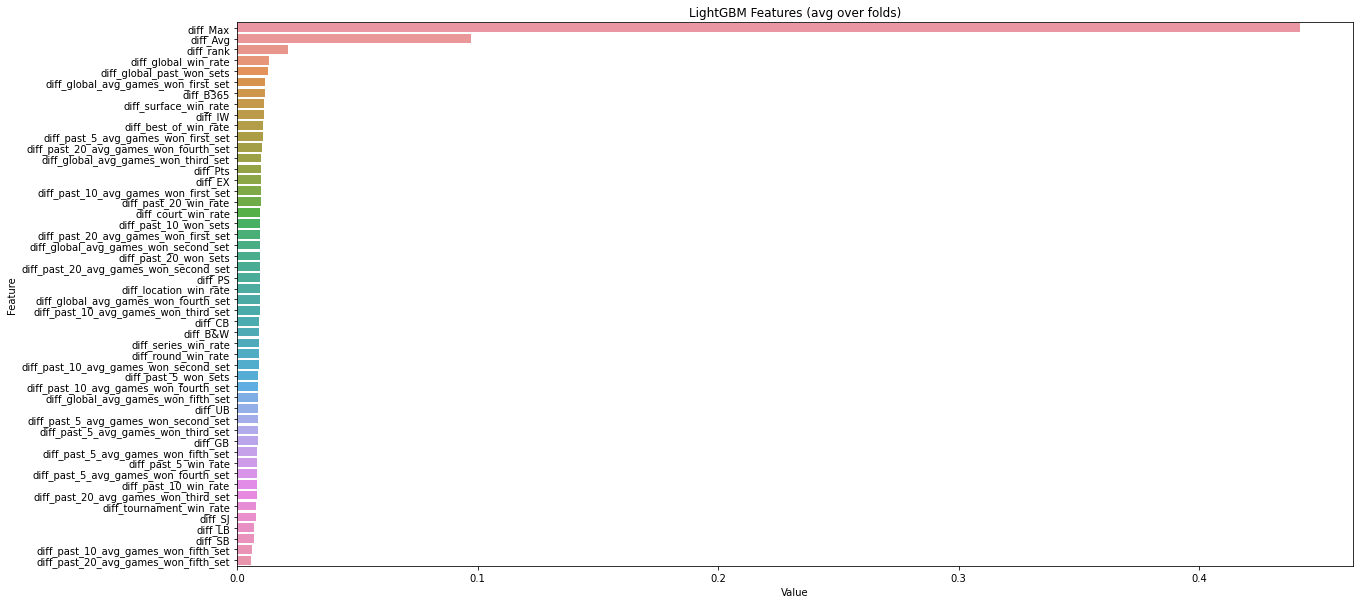

In [41]:
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_, normalize_data_2016.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features (avg over folds)')


Regarding the top 5 features importance ploted (on average over several runs) from our trained XGBClassifier, we can view the model's logic when making prediction:
- 1) The player's **Max odds**.
- 2) The player's **Avg odds**.
- 3) With no surpise the players' **rank** is the most important determinant feature.
- 4) The players' global win rate associated.
- 4) The player's past won sets on average.

Odds are discriminative, meaning that bookmakers' predictions matter a lot. And that's why it is interesting to try to build a betting strategy to beat them.

##### Errors analysis

[[0.72083981 0.27916019]
 [0.30820896 0.69179104]]


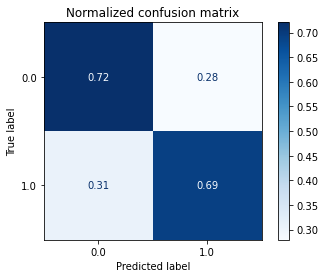

In [42]:
title = "Normalized confusion matrix"

conf_matrix = plot_confusion_matrix(best_model, X_val, y_val, cmap=plt.cm.Blues, normalize='true')
conf_matrix.ax_.set_title(title)

print(conf_matrix.confusion_matrix)

As expected, the randomness of the player order in the dataset makes the model robust to classes mispredictions.

<AxesSubplot:title={'center':"Confidence probability of model's predictions"}, ylabel='Density'>

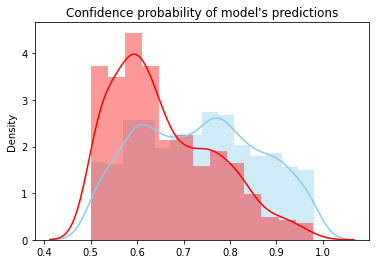

In [43]:
y_pred_val = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)

true_prediction_confidence = np.max(y_pred_proba[y_pred_val == y_val], axis=1)
false_prediction_confidence = np.max(y_pred_proba[y_pred_val != y_val], axis=1)


title = "Confidence probability of model's predictions"
sns.distplot(true_prediction_confidence , color="skyblue", label="True prediction").set_title(title)
sns.distplot(false_prediction_confidence , color="red", label="False prediction")


From this graph we can deduce that our model's confidence tend to be more reliable over a certain confidence threshold, **0.58**. We will 

#### Trying to make € out of our Tennis predictor

Our dataset is made of decimal odds, meaning that if I bet 1€ on Federer .R with a odd of 1.5 and win my bet, I take back 1.5€. Otherwise, I loose my initial 1€ bet.

In this section, we will use our model's prediction to build a strategy bet on the unseen Tennis matchs of 2017.

To do so, we apply the following strategy on all 2017 matchs:
- **Step 1**: look at the confidence of our prediction on a given match, if this confidence is above a specified threshold (0.58) we bet and go to Step 2, otherwise we don't and wait for the next match and retake Step 1.
- **Step 2**: choose the bookmaker that offers the best odds with respect to the maximization of our expected gain.


Let's see our cumulative gain applying this strategy on 2017 matchs.

In [44]:
_, _, X_test, y_test = split_datasets(normalize_data_2017, evaluation_year=2017)

In [46]:
start_index_2017 = 47028

def get_predicted_winner_max_odds(i, prediction):
    # we predict player 1 as winner
    if prediction == 1:
        predicted_winner = dataset.loc[start_index_2017 + i]['player_1']

    # we predict player 2 as winner 
    else:
        predicted_winner = dataset.loc[start_index_2017 + i]['player_2']
        
    if df_atp.loc[start_index_2017 + i]['Winner'] == predicted_winner:
        max_odds = df_atp.loc[start_index_2017 + i]['MaxW']
        return max_odds
    
    if df_atp.loc[start_index_2017 + i]['Loser'] == predicted_winner:
        max_odds = df_atp.loc[start_index_2017 + i]['MaxL']
        return max_odds
        




betting_threshold = 0.9
betting_value = 10
cumulative_profit = 0
count_bet = 0

predictions = final_model.predict(X_test)
predictions_proba = np.max(final_model.predict_proba(X_test), axis=1)

# Initial strategy
for i, proba in enumerate(predictions_proba):
    if proba >= betting_threshold:
        #print("i")
        count_bet += 1
        
        # we systematically choose the max odds in order to maximize our profit
        max_odds = get_predicted_winner_max_odds(i, predictions[i])
           
        # when max_odds is not available
        if np.isnan(max_odds):
            continue
        
        # Correct prediction
        if predictions[i] == y_test[i]:
            cumulative_profit += (betting_value * max_odds) - betting_value
            
        # Incorrect prediction
        else:
            cumulative_profit -= betting_value

print(f"Profit made with initial strategy for {count_bet} bets of 10€:", round(cumulative_profit, 4), "€")

Profit made with initial strategy for 222 bets of 10€: -71.6


----

Another strategy could be to bet less and look at interesting odds (high odds).

For every match do: 
- Look at the max odds of a match, if the odds is interesting (>=2) we bet according to our model's prediction. Otherwise, we don't bet and wait for next match.

In [47]:
betting_value = 10
cumulative_profit = 0
count_bet = 0

predictions = final_model.predict(X_test)
predictions_proba = np.max(final_model.predict_proba(X_test), axis=1)

# Second strategy
for i, proba in enumerate(predictions_proba):
    max_odds = get_predicted_winner_max_odds(i, predictions[i])
    
    # when max_odds is not available
    if np.isnan(max_odds):
            continue
            
    if max_odds >= 2:  
        count_bet += 1
        # Correct prediction
        if predictions[i] == y_test[i]:
            cumulative_profit += (betting_value * max_odds) - betting_value

        # Incorrect prediction
        else:
            cumulative_profit -= betting_value

print(f"Profit made with second strategy for {count_bet} bets of 10€:", round(cumulative_profit, 4), "€")

Profit made with second strategy for 71 bets of 10€: 101.8


#### Potential improvements

Further features engineering:
- Head-to-head statistics. Indeed, the specific statistics between two players may be relevant. For instance, Federer R. seems to have specific issue winning againts Nadal R. at Roland Garros.
- Track bookmaker's odds reliability regarding their past prediction to weight their importance in the model predictions.
- Use external source of structured data like weather or detailed player's statistics such as number of aces, winning shots, passing shots...
- Use external source of unstructured data like player's interview, coach's interview or social media posts that might give insight about the mental state, the shape or fatigue of a player before a match.

----

Different modelisation approach:
- Explore different models (random forest, neural networks, stacking models...).
- Reframe the dataset as a pure Time Series problem, trying to use RNN approach in order to alleviate our heavily handmade engineered features and take into account the new match statistics on the fly.
